In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [2]:
# Probably need to change this if your on MAC
spark = (
    SparkSession.builder.appName("Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/18 18:33:54 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.18.145.6 instead (on interface eth0)
24/09/18 18:33:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 18:33:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
merchant_fraud = spark.read.parquet("../data/curated/merchant_fraud")
merchant_fraud.show()

+------------+--------------+--------------------------+
|merchant_abn|order_datetime|merchant_fraud_probability|
+------------+--------------+--------------------------+
| 19492220327|    2021-11-28|        44.403658647495355|
| 31334588839|    2021-10-02|         42.75530083865367|
| 19492220327|    2021-12-22|        38.867790051131095|
| 82999039227|    2021-12-19|          94.1347004808891|
| 90918180829|    2021-09-02|         43.32551731714902|
| 31334588839|    2021-12-26|         38.36165958070444|
| 23686790459|    2021-12-10|          79.4543441508535|
| 14827550074|    2021-11-26|         46.45775596795885|
| 31334588839|    2021-11-26|         36.20971272078342|
| 19492220327|    2021-12-18|        33.819672154331755|
| 31334588839|    2021-11-29|        35.386213297375505|
| 14827550074|    2021-12-05|         43.85519494291279|
| 19492220327|    2021-11-18|        32.193139919494016|
| 93260930990|    2021-11-30|         37.87197154172081|
| 90918180829|    2021-09-16|  

In [4]:
consumer_fraud = spark.read.parquet("../data/curated/consumer_fraud")
consumer_fraud = consumer_fraud.withColumnRenamed("fraud_probability","consumer_fraud_probability")
consumer_fraud.show()

+-------+--------------+--------------------------+
|user_id|order_datetime|consumer_fraud_probability|
+-------+--------------+--------------------------+
|   6228|    2021-12-19|          97.6298077657765|
|  21419|    2021-12-10|         99.24738020302328|
|   5606|    2021-10-17|         84.05825045251777|
|   3101|    2021-04-17|         91.42192091901347|
|  22239|    2021-10-19|         94.70342477508035|
|  16556|    2022-02-20|         89.65663294494827|
|  10278|    2021-09-28|         83.59136689427714|
|  15790|    2021-12-30|         71.77065889280253|
|   5233|    2021-08-29|         85.87123303878818|
|    230|    2021-08-28|         86.28328808934151|
|  13601|    2021-12-26|         83.13696487489679|
|   6383|    2021-09-15|          66.2676451623754|
|   3513|    2022-02-27|         75.16981192247916|
|  18658|    2021-10-19|         82.98609082999361|
|   5965|    2021-11-14|         69.37164467869053|
|  18714|    2021-11-14|         83.78813794627237|
|  22957|   

In [5]:
full_transaction = spark.read.parquet("../data/curated/full_transactions.parquet")
full_transaction = full_transaction.dropDuplicates(["order_id"])

full_transaction.write.mode('overwrite').parquet("../data/curated/full_transactions")
full_transaction = spark.read.parquet("../data/curated/full_transactions.parquet")

24/09/18 18:34:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
full_transaction = full_transaction.withColumn('order_time', F.unix_timestamp('order_datetime'))
full_transaction = full_transaction.withColumnRenamed("fraud_probability", "consumer_fraud_probability")
full_transaction.show()

+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+-----------

In [7]:
continuous_features = ["dollar_value", "tags3", "order_time", "Average_household_size", "Median_age_persons", "Median_tot_fam_inc_weekly", "Median_tot_hhd_inc_weekly", "Tot_M", "Tot_P", "Tot_F"]
categorical_features = ["state", "gender",  "tags2"]

In [8]:
# So we need to select our valid values first, we will take from the merchant fraud probability that we know.
merchant_fraud = spark.read.parquet("../data/curated/merchant_fraud")
print(f"Number of unique entries: {merchant_fraud.select('merchant_abn', 'order_datetime').distinct().count()}")
print(f"Number of entries: {merchant_fraud.count()}")

Number of unique entries: 114
Number of entries: 114


In [9]:
full_transaction = full_transaction.na.drop(subset=["merchant_name"])
full_transaction = full_transaction.na.drop(subset=["Median_age_persons"])

training_data = full_transaction.join(merchant_fraud, on=['merchant_abn', 'order_datetime','merchant_fraud_probability'], how='inner')
consumer_training_data = full_transaction.join(consumer_fraud, on=['user_id', 'order_datetime','consumer_fraud_probability'], how='inner')


null_merchant_fraud = full_transaction.filter(F.col("merchant_fraud_probability").isNull())
null_consumer_fraud = full_transaction.filter(F.col("consumer_fraud_probability").isNull())

full_transaction.show()


+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+--------+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+-----------

In [10]:
training_data.show()

+------------+--------------+--------------------------+--------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|merchant_abn|order_datetime|merchant_fraud_probability|postcode|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+------------+--------------+--------------------------+--------+-------+-----------+------------------+--------------------+-----------------+-----+-----------+--------------------------+--------------------+-----

In [11]:
null_merchant_fraud.count()

11367269

In [12]:
null_counts = full_transaction.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in full_transaction.columns])

null_counts.show()

+--------+--------------+------------+-------+-----------+------------+--------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value|order_id|consumer_name|state|gender|consumer_fraud_probability|merchant_name|tags|tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|order_time|
+--------+--------------+------------+-------+-----------+------------+--------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|       0|             0|         

In [13]:
for i in categorical_features:
    indexer = StringIndexer(inputCol=i, outputCol=f"{i}_index", handleInvalid="keep").fit(training_data)
    training_data = indexer.transform(training_data)
    consumer_training_data = indexer.transform(consumer_training_data)
    null_merchant_fraud = indexer.transform(null_merchant_fraud)
    null_consumer_fraud = indexer.transform(null_consumer_fraud)

for j in categorical_features:
    encoder = OneHotEncoder(inputCol=f"{j}_index", outputCol=f"{j}_vector").fit(training_data)
    training_data = encoder.transform(training_data)
    consumer_training_data = encoder.transform(consumer_training_data)
    null_merchant_fraud = encoder.transform(null_merchant_fraud)
    null_consumer_fraud = encoder.transform(null_consumer_fraud)

assembler = VectorAssembler(
    inputCols=[f"{k}_vector" for k in categorical_features] + continuous_features,
    outputCol="feature_vector",
    handleInvalid="keep"
)

training_data = assembler.transform(training_data)
consumer_training_data = assembler.transform(consumer_training_data)
null_merchant_fraud = assembler.transform(null_merchant_fraud)
null_consumer_fraud = assembler.transform(null_consumer_fraud)


In [14]:
train_data, test_data = training_data.randomSplit([0.8, 0.2])
consumer_train_data, consumer_test_data = consumer_training_data.randomSplit([0.8, 0.2])
LR =LinearRegression(featuresCol='feature_vector', labelCol='merchant_fraud_probability', regParam=0.1)
LR2 =LinearRegression(featuresCol='feature_vector', labelCol='consumer_fraud_probability', regParam=0.1)

merchant_LR_model = LR.fit(train_data)
consumer_LR_model = LR2.fit(consumer_train_data)

merchant_results = merchant_LR_model.transform(test_data)
consumer_results = consumer_LR_model.transform(consumer_test_data)

merchant_results.select(["prediction","merchant_fraud_probability"]).show(900)
consumer_results.select(["prediction","consumer_fraud_probability"]).show(900)
print("Merchant RMSE:", merchant_LR_model.summary.rootMeanSquaredError)
print("Merchant MAE:", merchant_LR_model.summary.meanAbsoluteError)

print("Consumer RMSE:", consumer_LR_model.summary.rootMeanSquaredError)
print("Consumer MAE:", consumer_LR_model.summary.meanAbsoluteError)

merchant_pandas_results = merchant_results.toPandas()
merchant_mse = mean_squared_error(merchant_pandas_results['prediction'], merchant_pandas_results['merchant_fraud_probability'])
merchant_rmse = np.sqrt(merchant_mse)
print("Manual Merchant RMSE:", merchant_rmse)

consumer_pandas_results = consumer_results.toPandas()
consumer_mse = mean_squared_error(consumer_pandas_results['prediction'], consumer_pandas_results['consumer_fraud_probability'])
consumer_rmse = np.sqrt(consumer_mse)
print("Manual Consumer RMSE:", consumer_mse)


24/09/18 18:34:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/18 18:34:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+------------------+--------------------------+
|        prediction|merchant_fraud_probability|
+------------------+--------------------------+
| 40.81341650121249|        25.054391991473924|
| 40.81341650121249|        25.054391991473924|
| 39.37524344713336|        24.872618445353506|
|  33.7682099782719|         42.75530083865367|
|39.853797716307554|         42.75530083865367|
|31.574213454473693|         61.92380860960476|
|32.029388612840535|         61.92380860960476|
|  30.8007304341221|         61.92380860960476|
|33.669476399190785|        31.537398474248473|
|  33.5654177505038|        31.537398474248473|
| 29.84877456344134|        29.102418916409913|
| 29.25700772671985|        29.102418916409913|
|29.853442159576048|        29.102418916409913|
| 29.77205664678081|        29.102418916409913|
| 29.39103698451163|        29.102418916409913|
| 29.77642838968427|        29.102418916409913|
|30.024970300573045|        29.102418916409913|
|29.581294954864347|        29.102418916

Manual Consumer RMSE: 82.74396885238862


In [15]:
#results.filter(F.col("merchant_fraud_probability").isNull()).show()

In [16]:
null_counts = full_transaction.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in full_transaction.columns])

null_counts.show()

+--------+--------------+------------+-------+-----------+------------+--------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value|order_id|consumer_name|state|gender|consumer_fraud_probability|merchant_name|tags|tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|order_time|
+--------+--------------+------------+-------+-----------+------------+--------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|       0|             0|         

In [17]:
full_transaction.filter(F.col('Median_age_persons').isNull()).select("postcode").distinct().show(600)

+--------+
|postcode|
+--------+
+--------+



In [18]:
null_merchant_fraud.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- tags1: string (nullable = true)
 |-- tags2: string (nullable = true)
 |-- tags3: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- Median_age_persons: double (nullable = true)
 |-- Median_tot_fam_inc_weekly: double (nullable = true)
 |-- Median_tot_hhd_inc_weekly: double (nullable = true)
 |-- Average_household_size: double (nullable = true)
 |-- Tot_M: double (nullable = true)
 |-- Tot_P: double (n

In [19]:
full_transaction.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- tags1: string (nullable = true)
 |-- tags2: string (nullable = true)
 |-- tags3: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- Median_age_persons: double (nullable = true)
 |-- Median_tot_fam_inc_weekly: double (nullable = true)
 |-- Median_tot_hhd_inc_weekly: double (nullable = true)
 |-- Average_household_size: double (nullable = true)
 |-- Tot_M: double (nullable = true)
 |-- Tot_P: double (n

In [20]:
LR =LinearRegression(featuresCol='feature_vector', labelCol='merchant_fraud_probability', regParam=0.1)
LR_model = LR.fit(training_data)
null_values = LR_model.transform(null_merchant_fraud)

In [21]:
LR2 =LinearRegression(featuresCol='feature_vector', labelCol='consumer_fraud_probability', regParam=0.1)
LR2_model = LR2.fit(consumer_training_data)
consumer_null_values = LR2_model.transform(null_consumer_fraud)

In [22]:
null_values = null_values.select("order_id","prediction")
null_values = null_values.withColumnRenamed("prediction","predicted_merchant_fraud_probability")
full_transaction = full_transaction.join(null_values, on="order_id", how = "left")
full_transaction = full_transaction.withColumn("merchant_fraud_probability", F.when(F.col("merchant_fraud_probability").isNull(), 
                                                                                      F.col("predicted_merchant_fraud_probability"))
                                                                                      .otherwise(F.col("merchant_fraud_probability")))
full_transaction = full_transaction.drop("predicted_merchant_fraud_probability")

In [23]:
consumer_null_values = consumer_null_values.select("order_id","prediction")
consumer_null_values = consumer_null_values.withColumnRenamed("prediction","predicted_consumer_fraud_probability")
full_transaction = full_transaction.join(consumer_null_values, on="order_id", how = "left")
full_transaction = full_transaction.withColumn("consumer_fraud_probability", F.when(F.col("consumer_fraud_probability").isNull(), 
                                                                                      F.col("predicted_consumer_fraud_probability"))
                                                                                      .otherwise(F.col("consumer_fraud_probability")))
full_transaction = full_transaction.drop("predicted_consumer_fraud_probability")

In [24]:
null_counts = full_transaction.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in full_transaction.columns])

null_counts.show()

+--------+--------+--------------+------------+-------+-----------+------------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value|consumer_name|state|gender|consumer_fraud_probability|merchant_name|tags|tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|order_time|
+--------+--------+--------------+------------+-------+-----------+------------+-------------+-----+------+--------------------------+-------------+----+-----+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+----------+
|       0|       0|             0|

In [25]:
full_transaction.show()

+--------------------+--------+--------------+------------+-------+-----------+------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+----------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|    consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|order_time|
+--------------------+--------+--------------+------------+-------+-----------+------------------+-----------------+-----+-----------+--------------------------+--------------------+--------------------+-----------

Text(0, 0.5, 'Density')

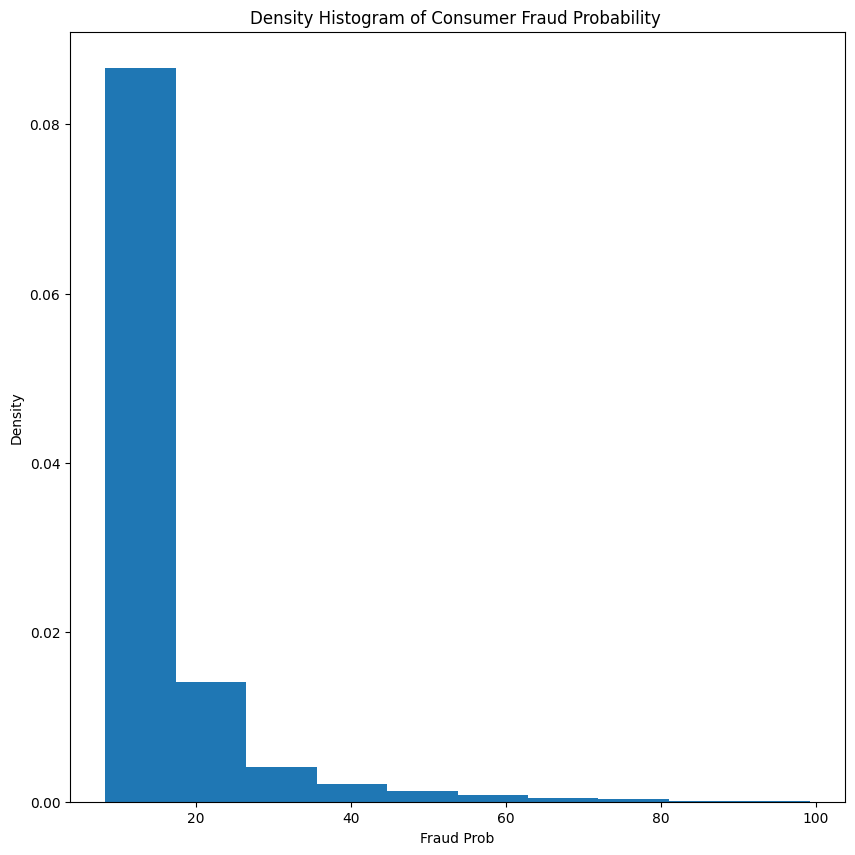

In [26]:
consumer_fraud = spark.read.parquet("../data/curated/consumer_fraud")
fraud = list(consumer_fraud.select("fraud_probability").toPandas()["fraud_probability"])
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True)
plt.title('Density Histogram of Consumer Fraud Probability ')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

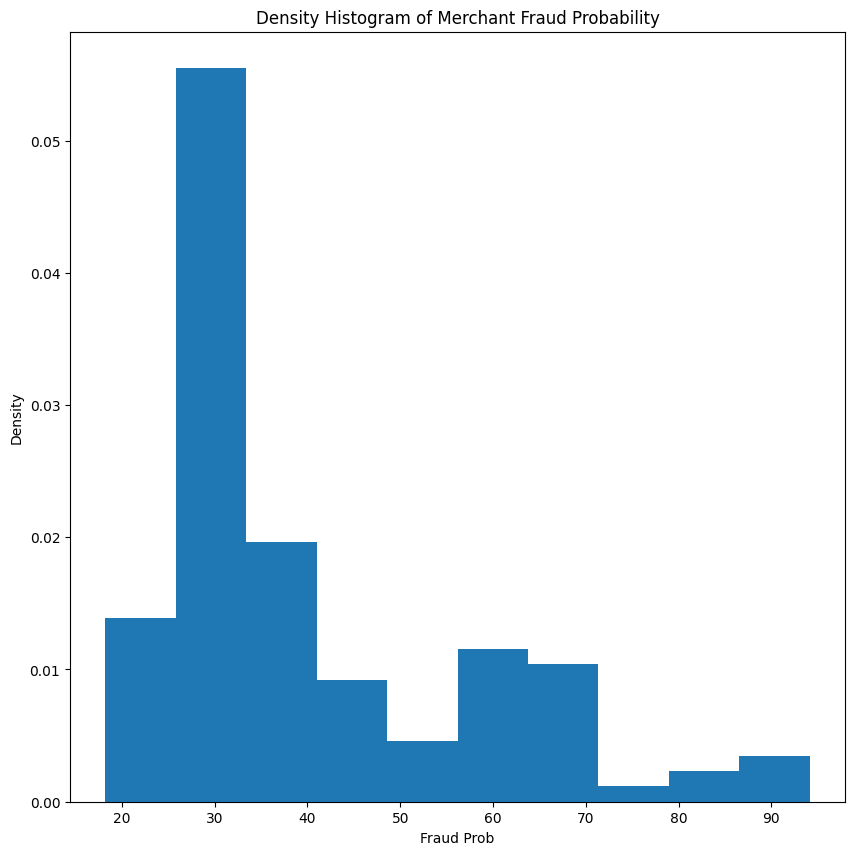

In [27]:
fraud = list(merchant_fraud.select("merchant_fraud_probability").toPandas()["merchant_fraud_probability"])
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True)
plt.title('Density Histogram of Merchant Fraud Probability')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')

In [28]:
full_transaction.write.mode('overwrite').parquet("../data/curated/full_transactions")